In [101]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

In [102]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

In [103]:
#path = '/content/drive/MyDrive/Image_recognition/HW4/'
path = ''
x_train = np.load(path + "x_train.npy")
y_train = np.load(path + "y_train.npy")
x_test = np.load(path + "x_test.npy")
y_test = np.load(path + "y_test.npy")

In [104]:
# 550 data with 300 features
print(x_train.shape)

(550, 300)


In [105]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [106]:
def cross_validation(x_train, y_train, k=5):
    n_samples = x_train.shape[0]
    indices = np.arange(n_samples)
    np.random.seed()
    np.random.shuffle(indices)
    folds = []
    size = n_samples//k + 1
    for i in range(n_samples%k):
        start = i * size
        fold = indices[start:start+size]
        folds.append(fold)
    size = n_samples // k
    for i in range(n_samples%k, k):
        start = i * size
        fold = indices[start:start+size]
        folds.append(fold)
    folds = np.asarray(folds)
    kfold = []
    for i in range(k):
        #train = folds[np.arange(k)!=i].reshape(-1)
        #print('HHHHHHHHHHHHHHHH:',folds[np.arange(k)!=i])
        train = np.concatenate(folds[np.arange(k)!=i])
        #print('TTTTTTTTTTTTTTTT:',train)
        val = folds[i]
        kfold.append([train, val])
    return kfold

In [108]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 55 # The number of data in each validation fold should equal to training data divieded by K

## example

In [109]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
KFold_Data= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    KFold_Data.append([train_index, val_index])

Split: 1, Training index: [ 0  2  3  4  7  8  9 10 11 12 14 15 16 17 18 19], Validation index: [ 1  5  6 13]
Split: 2, Training index: [ 1  2  4  5  6  7  8  9 10 11 12 13 14 15 18 19], Validation index: [ 0  3 16 17]
Split: 3, Training index: [ 0  1  2  3  4  5  6  7  9 11 13 14 16 17 18 19], Validation index: [ 8 10 12 15]
Split: 4, Training index: [ 0  1  2  3  4  5  6  8 10 11 12 13 15 16 17 18], Validation index: [ 7  9 14 19]
Split: 5, Training index: [ 0  1  3  5  6  7  8  9 10 12 13 14 15 16 17 19], Validation index: [ 2  4 11 18]


In [110]:
assert len(KFold_Data) == 5 # should contain 5 fold of data
assert len(KFold_Data[0]) == 2 # each element should contains index of training fold and validation fold
assert KFold_Data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [111]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [127]:
def svm_gridsearch(x, y, kfold_data, candidate_C, candidate_gamma):
    gd = []
    best_C, best_gamma, max_acc = 0, 0, 0
    for C in candidate_C:
        temp = []
        for gamma in candidate_gamma:
            all_acc = []
            for f in kfold_data:
                clf = SVC(C=C, kernel='rbf', gamma=gamma)
                clf.fit(x[f[0]], y[f[0]])
                y_pred = clf.predict(x[f[1]])
                acc = accuracy_score(y_pred, y[f[1]])
                all_acc.append(acc)
            avg_acc = np.average(np.asarray(all_acc))
            #print(f'C={C}, gamma={gamma}, avg acc={avg_acc:.2f}')
            temp.append(avg_acc)
            if avg_acc >= max_acc:
                best_C = C
                best_gamma = gamma
                max_acc = avg_acc
        gd.append(temp)
    gridsearch = np.asarray(gd)
    return gridsearch, (best_C, best_gamma), max_acc

In [128]:
cand_C = [1e-2, 1e-1, 1, 10, 1e2, 1e3, 1e4]
cand_gamma = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3]
kfold_data = cross_validation(x_train, y_train, k=3)
gridsearch, best_parameters, max_acc = svm_gridsearch(x_train, y_train, kfold_data, cand_C, cand_gamma)
print(f'Best parameter (C, gamma): {best_parameters} acc: {max_acc:.2f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Best parameter (C, gamma): (10000.0, 0.0001) acc: 0.85


In [120]:
print(best_parameters)

(10000.0, 0.0001)


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

In [121]:
import matplotlib
import matplotlib.pyplot as plt

In [122]:
def heatmap(data, rlabels, clabels, ax=None, **kwargs):
    if not ax:
        ax = plt.gca()
    im = ax.imshow(data, **kwargs)
    cbar = ax.figure.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(clabels)
    ax.set_yticklabels(rlabels)
    plt.setp(
        ax.get_yticklabels(), rotation=90,
        va='bottom', ha='center', rotation_mode='anchor')
    ax.set_xlabel('Gamma Parameter')
    ax.set_ylabel('C Parameter')
    ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)
    return im, cbar

In [123]:
def annotate_heatmap(im, valfmt, threshold=None):
    data = im.get_array()
    if threshold is None:
        threshold = im.norm(data.max())/2.
    else:
        threshold = im.norm(threshold)
        

    kw = dict(horizontalalignment="center", verticalalignment="center")

    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    texts = []
    textcolors = ['black', 'white']
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j])>threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)
    return texts


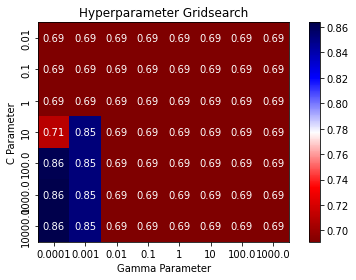

In [124]:
fig, ax = plt.subplots()
im, cbar = heatmap(gridsearch, cand_C, cand_gamma, ax=ax, cmap='seismic_r')
texts = annotate_heatmap(im, valfmt='{x:.2f}', threshold=0.2)
#print(texts)
plt.title('Hyperparameter Gridsearch')
fig.tight_layout()
plt.savefig('gridsearch_svc.png', dpi=1000, transparent=True)
#plt.clf()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [126]:
print(f'Best parameter (C, gamma) on training set: {best_parameters}')
best_C, best_gamma = best_parameters
best_model = SVC(C=best_C, kernel='rbf', gamma=best_gamma)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
print(f"Accuracy score on testing set: {accuracy_score(y_pred, y_test)}" )

Best parameter (C, gamma) on training set: (10000.0, 0.0001)
Accuracy score on testing set: 0.90625
